# Temporal Difference

A combination of MC and DP ideas:  like Monte Carlo, it learn directly from raw experience (without a model), like dynamic programming, it update estimates based on other learned estimates (without waiting for a final outcome).

$\displaystyle V(S_t) = V(S_t) + \alpha_t [G_{t:t+1} - V(S_t)] $

In [1]:
import numpy as np

def decay_alpha(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [2]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

We write the prediction function that works for Temporal-Difference:

In [3]:
def td(pi, env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, decay_episodes=350, n_episodes=500):

    nS = env.observation_space
        
    # initialize the variables needed
    V = np.zeros(nS, dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # calculate the learning rate schedule for all episodes
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);
    
    # loop for n_episodes
    for e in range(n_episodes):
        
        # get the initial state and then enter the interaction loop
        state, done = env.reset(), False
        
        while not done:
            
            # sample the policy pi for the action to take in state
            action = pi(state)
            
            # use the action to interact with the environment... 
            # roll out the policy one step
            next_state, reward, done, _ = env.step(action)
            
            # update V(s)
            td_target = reward + gamma * V[next_state]
            td_error = td_target - V[state]
            V[state] = V[state] + alphas[e] * td_error
            
            # update the state variable for the next iteration
            state = next_state
            
        V_track[e] = V
        
    return V, V_track

We ran the policy evaluation algorithms on the Random Walk (RW) environment.

In [4]:
import numpy as np
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 7
        self._state = np.random.choice([1,2,3,4,5])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: 
            raise ValueError('Episode has terminated');
        
        if action not in [0, 1]: 
            raise ValueError('Invalid action');
        
        self._state += np.random.choice([-1, 1])
        
        reward = 0
        
        if self._state < 1: 
            self._done = True
        
        if self._state > 5: 
            self._done = True; 
            reward = 1
        
        return self._state, reward, self._done, 0  # obs, rew, done

In [5]:
random_walk = RandomWalk()

In [6]:
def pi(state):
    return 1

We use the Temporal-Difference prediction algorithm and show the estimates over episodes

In [7]:
V_td, V_td_track = td(pi, random_walk, n_episodes=500)

In [8]:
print(V_td)

[0.         0.17253596 0.33812265 0.50047324 0.65620351 0.83229692
 0.        ]


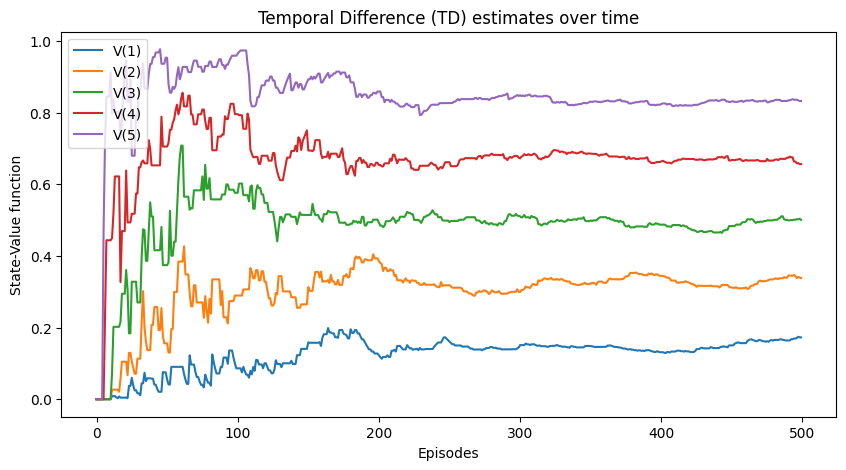

In [9]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)']
plt.figure(figsize=(10,5))
plt.plot(V_td_track[:,1:6])
plt.title('Temporal Difference (TD) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()